In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import set_config

pd.set_option('display.max_columns', None)
set_config(display='diagram')

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost

from sklearn.feature_selection import SelectPercentile, mutual_info_regression

# House Prices Challenge

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/ML/kaggle-batch-challenge.png' width=600>

This is my entry to the Kaggle competition - [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

**Challenge description:**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# Load Data

Data overview:

- `train.csv` is the (1460 * 81) training set containing features and the target.
- `test.csv` is the (1459 * 80) testing set without the associated target.
- `sample_submission.csv` describes the format required for submission.
- `data_description.txt` describes the columns.


In [2]:
training_data = pd.read_csv('data/train.csv')
training_df = pd.DataFrame(training_data)
training_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [3]:
#Splitting the data into X and y for the features and the target respectively
X = training_df.drop(columns=['SalePrice','Id'])
y = training_df['SalePrice']

# Baseline Model

## Initial feature overview

In [4]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

Storing the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set.

In [5]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations.

We can reduce the number of categorical features with 2 main strategies:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model.
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly.

Plotting the **histogram** of number of unique value per categorical feature to see which features would be good to cut in order to simplify the model.

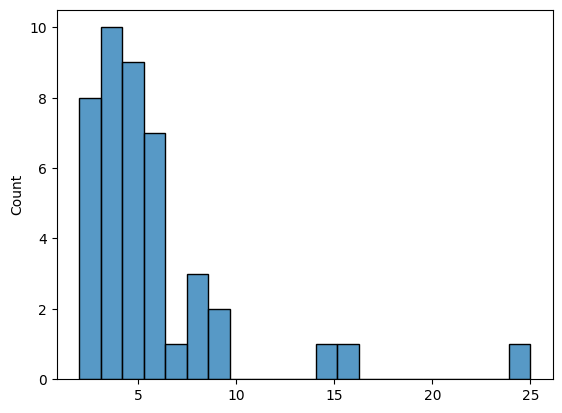

In [6]:
sns.histplot(data=feat_categorical_nunique);

To begin, we could remove all features that have 7 unique values or more, and one-hot-encode all the others.

In [7]:
#Storing names of columns to keep
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 7]
lst = list(feat_categorical_small.reset_index()['index'])
lst

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

## Baseline pipeline

### Preprocessing

Let's code a basic preprocessing pipeline.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values
- Drop all others features


For numerical features
- Simple-Impute with mean
- Min-Max Scale 


In [8]:
# Impute numerical values:
num_transformer = Pipeline([('num_imputer', SimpleImputer(strategy='mean')),
                            ('scaler', MinMaxScaler())])

# Encode categorical values
cat_transformer = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

# Parallelize "num_transformer" and "cat_transfomer"
preprocessor = ColumnTransformer(
    [('num_tr', num_transformer,
      make_column_selector(dtype_include=['int64', 'float64'])),
     ('cat_tr', cat_transformer, lst)],
    remainder='drop')

preproc_baseline = preprocessor
preproc_baseline

ColumnTransformer(transformers=[('num_tr',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x128b49a20>),
                                ('cat_tr',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['MSZonin...LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [9]:
processed_df = pd.DataFrame(preproc_baseline.fit_transform(X))
processed_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,0.064212,0.140098,0.119780,0.413559,0.0,0.259231,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.500000,0.000000,0.936364,0.50,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.00000,0.090909,0.50,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,0.121575,0.206547,0.212942,0.000000,0.0,0.174830,0.000000,0.5,0.666667,0.0,0.375,0.333333,0.333333,0.333333,0.690909,0.50,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.363636,0.25,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,0.185788,0.150573,0.134465,0.419370,0.0,0.273549,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.333333,0.333333,0.918182,0.50,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.00000,0.727273,0.50,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,0.231164,0.123732,0.143873,0.366102,0.0,0.260550,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.416667,0.333333,0.890909,0.75,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.00000,0.090909,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0

### Add a simple model to the pipeline

In [10]:
#We will use a decision tree regressor for our baseline model.
pipe_baseline = make_pipeline(preprocessor, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_tr',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x128b49a20>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknow...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### Cross-Validate

The Kaggle competition scores based on RMSLE (Root Mean Squared Least Logarithmic Error). We will need to create this metric manually.

We will create a scorer called `rmsle` that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
We will also create the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as a GridSearch tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [11]:
rmsle = make_scorer(mean_squared_log_error,
                    greater_is_better=True,
                    squared=False)
rmsle_neg = make_scorer(mean_squared_log_error,
                        greater_is_better=False,
                        squared=False)

In [12]:
#Cross validating our baseline model on the RMSLE
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5,
                                 scoring=rmsle).mean()
score_baseline

0.20737580296513855

### Baseline Prediction

In [13]:
#Importing test data to make predictions on.
test_data = pd.read_csv('data/test.csv')
test_df = pd.DataFrame(test_data)
X_test = test_df.drop(columns=['Id'])
X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GL

In [14]:
pipe_baseline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_tr',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x128b49a20>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknow...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [15]:
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline = pd.DataFrame(y_pred_baseline)
y_pred_baseline

,0
0,129000.0
1,157000.0
2,173000.0
3,175500.0
4,229456.0
...,...
1454,84500.0
1455,83000.0
1456,139000.0
1457,93500.0


❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. **Carefully read** the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [16]:
submission = pd.read_csv('data/sample_submission.csv').set_index('Id')

In [17]:
submission.SalePrice = np.array(y_pred_baseline)
submission.to_csv("data/submission_baseline.csv")

Our simple baseline model scored an RMSLE of 0.20892 upon submission to the competition. This will be our score to beat.

# Modeling

## Preprocessing

### Ordinal Encoding

In [18]:
feat_ordinal_dict = {
    #Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys())  #Sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype=np.int16,
    handle_unknown="use_encoded_value",
    unknown_value=-1  #Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"), encoder_ordinal,
    MinMaxScaler())

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int16'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

### Numerical Preprocessing

In [19]:
#Define numerical features
feat_numerical = sorted(
    X.drop(columns="MoSold").select_dtypes(
        include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(SimpleImputer(strategy="median"),
                                  MinMaxScaler())

### Nominal and Cyclical Encoding

In [20]:
#Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(
    list(set(X.drop(columns="MoSold")) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                OneHotEncoder(handle_unknown="ignore"))

#Apply a cosine transformer function to the month sold column in order to preserve cyclical nature of the months
def cosine_transformer(X):
    return pd.DataFrame(-np.cos(0.5236*X))

preproc_cyclical = FunctionTransformer(cosine_transformer, validate=False)

In [21]:
preproc = make_column_transformer((preproc_numerical, feat_numerical),
                                  (preproc_ordinal, feat_ordinal),
                                  (preproc_nominal, feat_nominal),
                                  (preproc_cyclical, 'MoSold'),
                                  remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLi...
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities']),
                                ('functiontransformer',
                                 FunctionTransformer(func=<function cosine_transformer at 0x128bfc4c0>),
                                 'MoSold')])

### Testing preprocesser

In [22]:
pd.DataFrame(preproc.fit_transform(X, y))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.000000,0.333333,0.0,0.064212,0.000000,0.000000,0.666667,0.386460,0.50,0.936364,0.259231,0.5,0.333333,0.033420,0.150685,0.0,0.235294,0.122500,0.00000,0.111517,0.500,0.666667,0.0,0.0,0.500000,0.140098,0.000000,0.949275,0.883333,0.50,0.75,0.25,1.000000,0.166667,0.75,1.0,0.50,0.666667,0.00,0.0,1.000000,0.6,0.666667,0.6,1.00,0.666667,1.0,1.0,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.499998
1,0.212942,0.000000,0.0,0.375,0.173281,0.000000,0.000000,0.5,0.121575,0.000000,0.333333,0.666667,0.324401,0.50,0.690909,0.174830,0.0,0.333333,0.038795,0.202055,0.0,0.000000,0.000000,0.00000,0.000000,0.875,0.555556,0.0,0.0,0.333333,0.206547,0.347725,0.753623,0.433333,0.25,0.75,1.00,0.833333,0.166667,0.75,1.0,0.50,0.333333,0.00,0.6,1.000000,0.6,0.666667,0.6,1.00,0.333333,1.0,1.0,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.866028
2,0.134465,0.419370,0.0,0.375,0.086109,0.000000,0.333333,0.0,0.185788,0.000000,0.333333,0.666667,0.428773,0.50,0.918182,0.273549,0.5,0.333333,0.046507,0.160959,0.0,0.235294,0.101250,0.00000,0.076782,0.500,0.666667,0.0,0.0,0.333333,0.150573,0.000000,0.934783,0.866667,0.50,0.75,0.50,1.000000,0.166667,0.75,1.0,0.50,0.666667,0.00,0.6,1.000000,0.6,0.666667,0.6,1.00,0.666667,1.0,1.0,0.666667,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.000011
3,0.143873,0.366102,0.0,0.375,0.038271,0.000000,0.333333,0.0,0.231164,0.492754,0.333333,0.333333,0.452750,0.75,0.8909

### Statistical Feature Selection

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

- We will add a `SelectPercentile` filter to the end of our `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain the target, according to the `mutual_info_regression`.

<details>
    <summary markdown='span'>🤔 What is mutual information?</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

In [61]:
preproc_transformer = make_column_transformer(
    (preproc_numerical,
     make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal), (preproc_nominal, feat_nominal))

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=80,  #Keep only 80% of all features
)

preproc = make_pipeline(preproc_transformer)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x128b49f00>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strat...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])]))])

In [62]:
preproc.fit_transform(X, y).shape

(1460, 216)

## Target Engineering

We are asked to minimize the RMS**L**E. Therefore we can transform our target to directly predict its `log`.
- Check out the histogram of the target `y` below.
- Normally distributed variables should be easier to predict with linear or parametric models. 

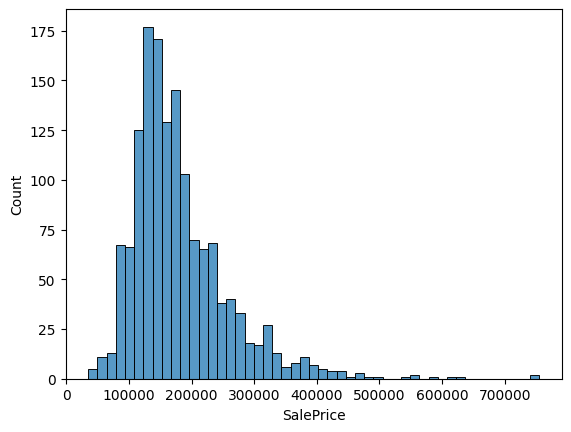

In [25]:
sns.histplot(y);

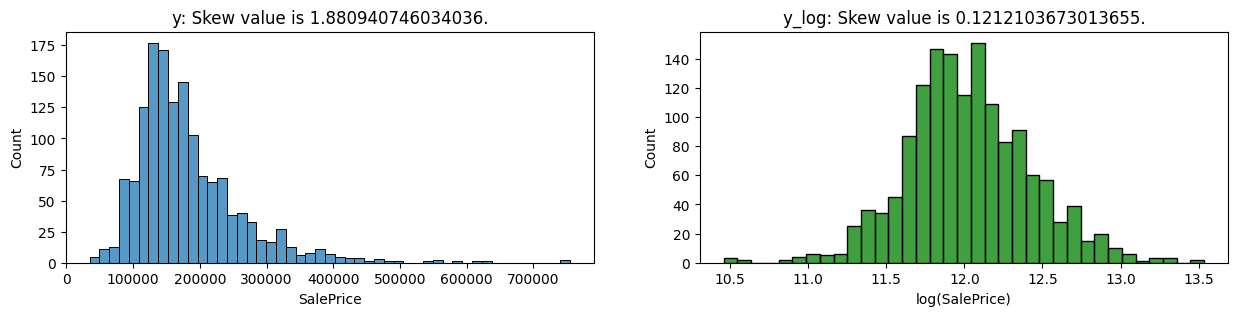

In [26]:
y_log = np.log(y)
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.histplot(y)
plt.title(f"y: Skew value is {scipy.stats.skew(y)}.")
plt.subplot(1, 2, 2)
sns.histplot(y_log, color='green')
plt.xlabel("log(SalePrice)")
plt.title(f"y_log: Skew value is {scipy.stats.skew(y_log)}.");

In [27]:
#Create a new scorer to minimize the error when predicting y_log
mse = make_scorer(mean_squared_error)

#Create a new scorer to maximize for GridSearch
mse_neg = make_scorer(mean_squared_error, greater_is_better=False)

## Model Selection ♻

### Stacked Ensemble

Testing different regressors to use in our ensemble stacking model. Model selection was based upon the assumption that a diverse range of models with low correlation will provide the most robust predictions when stacked together.

In [58]:
#Elastic Net
model = ElasticNet()
pipe_net = make_pipeline(preproc, model)
cross_val_score(pipe_net, X, y_log, cv=5, scoring=mse).mean()

0.15963698451502384

In [29]:
# param_grid =  {'elasticnet__alpha': np.linspace(0.01, 1, 20),
#               'elasticnet__l1_ratio': np.linspace(0.01, 1, 20)}
# search_net = GridSearchCV(pipe_net, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, verbose=2, scoring=mse_neg)

# search_net.fit(X, y_log);
# net_params = search_net.best_params_
# net_score = search_net.best_score_

In [30]:
net_params = {'alpha': 0.01, 'l1_ratio': 0.01}
net_score = -0.019914743040309307
print(net_params, net_score)

{'alpha': 0.01, 'l1_ratio': 0.01} -0.019914743040309307


In [60]:
#KNN Regressor
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)
cross_val_score(pipe_knn, X, y_log, cv=5, scoring=mse).mean()

0.04200490890605001

In [32]:
# param_grid =  {'kneighborsregressor__n_neighbors': [3,5,9,15,20,30]}
# search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, scoring=mse_neg)

# search_knn.fit(X, y_log);
# knn_params = search_knn.best_params_
# knn_score = search_knn.best_score_

In [33]:
knn_params = {'n_neighbors': 9}
knn_score = -0.04247054269337863
print(knn_params, knn_score)

{'n_neighbors': 9} -0.04247054269337863


In [34]:
#Support Vector Regressor
model = SVR()
pipe_svr = make_pipeline(preproc, model)
cross_val_score(pipe_svr, X, y_log, cv=5, scoring=mse).mean()

0.01702863658069258

In [35]:
# param_grid =  {'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                 'svr__gamma': ['scale','auto'],
#                 'svr__C': [0.5, 0.7, 1, 2, 5, 10],
#                 'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5]}
# search_svr = GridSearchCV(pipe_svr, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, verbose=2, scoring=mse_neg)

# search_svr.fit(X, y_log);
# svr_params = search_svr.best_params_
# svr_score = search_svr.best_score_

In [36]:
svr_params = {
    'svr__C': 1,
    'svr__epsilon': 0.01,
    'svr__gamma': 'scale',
    'svr__kernel': 'rbf'
}
svr_score = -0.01582681599064443
print(svr_params, svr_score)

{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'} -0.01582681599064443


In [37]:
model = RandomForestRegressor()
pipe_rf = make_pipeline(preproc, model)
cross_val_score(pipe_rf, X, y_log, cv=5, scoring=mse).mean()

0.020266043327413337

In [38]:
# param_grid =  {'randomforestregressor__n_estimators': [10,20,50,100,150],
#                'randomforestregressor__min_samples_leaf': [1,10,20],
#                'randomforestregressor__min_samples_split': [2,5,10]}
# search_rf = GridSearchCV(pipe_rf, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, verbose=2, scoring=mse_neg)

# search_rf.fit(X, y_log);
# rf_params = search_rf.best_params_
# rf_score = search_rf.best_score_

In [39]:
rf_params = {
    'randomforestregressor__min_samples_leaf': 1,
    'randomforestregressor__min_samples_split': 2,
    'randomforestregressor__n_estimators': 150
}
rf_score = -0.01993324593044949
print(rf_params, rf_score)

{'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 150} -0.01993324593044949


In [40]:
model = GradientBoostingRegressor()
pipe_gb = make_pipeline(preproc, model)
cross_val_score(pipe_gb, X, y_log, cv=5, scoring=mse).mean()

0.015768168655297194

In [41]:
# param_grid = {
#     'gradientboostingregressor__n_estimators': [3000, 2000, 1000],
#     'gradientboostingregressor__learning_rate': [0.05, 0.5, 1],
#     'gradientboostingregressor__max_depth': [4,8],
#     'gradientboostingregressor__max_features': ['sqrt'],
#     'gradientboostingregressor__min_samples_leaf': [15,20],
#     'gradientboostingregressor__min_samples_split': [10,20],
#     'gradientboostingregressor__loss': ['huber']
# }
# search_gb = GridSearchCV(pipe_gb,
#                          param_grid=param_grid,
#                          cv=5,
#                          n_jobs=-1,
#                          verbose=2,
#                          scoring=mse_neg)

# search_gb.fit(X, y_log)
# gb_params = search_gb.best_params_
# gb_score = search_gb.best_score_

In [42]:
gb_params = {
    'gradientboostingregressor__learning_rate': 0.05,
    'gradientboostingregressor__loss': 'huber',
    'gradientboostingregressor__max_depth': 4,
    'gradientboostingregressor__max_features': 'sqrt',
    'gradientboostingregressor__min_samples_leaf': 15,
    'gradientboostingregressor__min_samples_split': 10,
    'gradientboostingregressor__n_estimators': 2000
}
gb_score = -0.015114576190039048
print(gb_params, gb_score)

{'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_leaf': 15, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 2000} -0.015114576190039048


The KNN performed the worst out of the models tested and is therefore left out of the ensemble.

In [63]:
ensemble = StackingRegressor(estimators=[
    ("rf",
     RandomForestRegressor(min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=150)),
    ("gb",
     GradientBoostingRegressor(learning_rate=0.05,
                               loss='huber',
                               max_depth=4,
                               max_features='sqrt',
                               min_samples_leaf=15,
                               min_samples_split=10,
                               n_estimators=2000)),
    ("svr", 
     SVR(C=1, epsilon=0.01, gamma='scale', kernel='rbf')),
    ("net", 
     ElasticNet(alpha=0.01, l1_ratio=0.01)),
],
                             final_estimator=LinearRegression(),
                             cv=5)

In [64]:
pipe = make_pipeline(preproc, ensemble)
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x128b49f00>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImpute...
                 StackingRegressor(cv=5,
                                   estimators=[('rf',
                                                RandomForestRegressor(n_estimators=150)),
                                               ('gb',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          loss='huber',
                                                                          max_depth=4,
                                                                          max_features='sqrt',
                                                                          min_samples_leaf=15,
                                                                          min_samples_split=10,
                                                                          n_estimators=2000)),
                                               ('svr', SVR(C=1, epsilon=0.01)),
                                               ('net',
                                                ElasticNet(alpha=0.01,
                                                           l1_ratio=0.01))],
                                   final_estimator=LinearRegression()))])

In [65]:
%%time
score = cross_val_score(pipe, X, y_log, cv=5, scoring=mse).mean()
score

CPU times: user 6min 19s, sys: 6.97 s, total: 6min 26s
Wall time: 7min 19s


0.014097214965284436

In [66]:
pipe.fit(X,y_log)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x128b49f00>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImpute...
                 StackingRegressor(cv=5,
                                   estimators=[('rf',
                                                RandomForestRegressor(n_estimators=150)),
                                               ('gb',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          loss='huber',
                                                                          max_depth=4,
                                                                          max_features='sqrt',
                                                                          min_samples_leaf=15,
                                                                          min_samples_split=10,
                                                                          n_estimators=2000)),
                                               ('svr', SVR(C=1, epsilon=0.01)),
                                               ('net',
                                                ElasticNet(alpha=0.01,
                                                           l1_ratio=0.01))],
                                   final_estimator=LinearRegression()))])

In [67]:
y_pred = pipe.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.apply(lambda x: np.exp(x))
y_pred

,0
0,121556.503294
1,160336.792802
2,184659.599511
3,193023.048746
4,183999.578391
...,...
1454,81387.008178
1455,79819.367107
1456,160040.173958
1457,108730.486118


#### Ensemble Submission

In [68]:
submission = pd.read_csv('data/sample_submission.csv').set_index('Id')
submission.SalePrice = np.array(y_pred)
submission.to_csv("data/ensemble_submission.csv")

The stacked ensemble model scored an RMSLE of 0.11968 upon submission to the competition. An improvement on our baseline score.

### XG Boost

In [49]:
model = xgboost.XGBRegressor()
pipe_xgb = make_pipeline(preproc, model)
cross_val_score(pipe_gb, X, y_log, cv=5, scoring=mse).mean()

0.015809800421601145

In [50]:
# param_grid = {
#     'xgbregressor__max_depth': [5,6,7,8,9,10],
#     'xgbregressor__eta': [0.3,0.1,0.01],
#     'xgbregressor__seed': [5,6,7,8,9,10],
#     'xgbregressor__n_estimators': [100,300,600,1000]
# }
# search_xgb = GridSearchCV(pipe_xgb,
#                          param_grid=param_grid,
#                         cv=5,
#                          n_jobs=-1,
#                          verbose=2,
#                          scoring=mse_neg)

# search_xgb.fit(X, y_log)
# xgb_params = search_xgb.best_params_
# xgb_score = search_xgb.best_score_

In [51]:
xgb_params = {'xgbregressor__eta': 0.01, 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 1000, 'xgbregressor__seed': 8}
xgb_score = -0.015961128621527314

print(xgb_params, xgb_score)

{'xgbregressor__eta': 0.01, 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 1000, 'xgbregressor__seed': 8} -0.015961128621527314


In [52]:
model = xgboost.XGBRegressor()
pipe = make_pipeline(preproc, model)
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x128bf80a0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImpute...
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, ...))])

In [53]:
%%time
score = cross_val_score(pipe, X, y_log, cv=5, scoring=mse).mean()
score

CPU times: user 23.3 s, sys: 445 ms, total: 23.7 s
Wall time: 13.5 s


0.019419343259661916

In [54]:
pipe.fit(X,y_log)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x128bf80a0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImpute...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [55]:
y_pred = pipe.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.apply(lambda x: np.exp(x))
y_pred

,0
0,113857.296875
1,152845.421875
2,193192.796875
3,193563.281250
4,188822.625000
...,...
1454,78248.203125
1455,74224.703125
1456,168491.296875
1457,114725.007812


#### XGB Submission

In [56]:
submission = pd.read_csv('data/sample_submission.csv').set_index('Id')
submission.SalePrice = np.array(y_pred)
submission.to_csv("data/xgb_submission.csv")

The XGBoost scored an RMSLE of 0.14843 upon submission to the competition. Better than our baseline but not better than the ensemble stacking method.